In [15]:
import re
import pandas as pd
import os
import numpy as np
import sys
import matplotlib.pyplot as plt
import json
%matplotlib inline

rootdir = '/Users/lguillain/Documents/EPFL2018/Git-semester-project/data/papers/'

## loading content of txt files..

In [78]:
contents = []
i = 0
source = []
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        if 'txt' in file:
            i += 1
            path = os.path.join(subdir, file)
            with open(path) as file:
                try:
                    text = file.read()
                    contents.append(text)
                    source.append(path[len(rootdir):-4])
                except:
                    name, message, content = sys.exc_info()
                    print(message)

## extracting the reference function from the text

One attempt was to use special splitting:

In [80]:
#Example of extraction
t = 'Abrahamson, D. (2012). Discovery reconceived: Product before process. For the Learning of Mathematics, 32(1), 815.\nAbrahamson, D. (2015). The monster in the machine, or why educational technology needs embodied design. In\nV. R. Lee (Ed.),'
re.split(r'(?<=\.)\n', t)

['Abrahamson, D. (2012). Discovery reconceived: Product before process. For the Learning of Mathematics, 32(1), 815.',
 'Abrahamson, D. (2015). The monster in the machine, or why educational technology needs embodied design. In\nV. R. Lee (Ed.),']

In [81]:
#dealing with links at the end
t =  'dispositions. Science Education, 98(1), 36–63. https://doi.org/10.1002/sce.21083\nEdelson, D. C., & Joseph, D. M. (2004). The interest-driven learning design framework: motivating learning'
re.split(r'\n\n|((?<=(\.|\/|[a-z]))\n)|\n(?=[A-Z])',t)

['dispositions. Science Education, 98(1), 36–63. https://doi.org/10.1002/sce.21083',
 None,
 None,
 'Edelson, D. C., & Joseph, D. M. (2004). The interest-driven learning design framework: motivating learning']

#### The issue is that it undersplits, so we it's better to just use \n 

In [82]:
def ref_extraction(text, extract=False):
    """extracts refrerence section: works well on well formated documents"""
    mention = text.rfind("\nReferences")
    if mention == -1:
        mention = text.lower().rfind(" references")
    if mention == -1:
        mention =  text.lower().rfind("reference")
    #get reference section, account for different spelling
    acknowledgements = max(text.lower().find("acknowledgements"), text.lower().find('acknowledgments'))
    
    #handle case that acknowlege ments are before references
    if acknowledgements < mention:
        acknowledgements = -1
    ref = text[mention+len("references"):acknowledgements]
    
    #references = re.split(r'\n\n|((?<=(\.|\/|[a-z]))\n)|\n(?=[A-Z])',ref)
    references = re.split(r'\n', ref)
    
    ref = [r for r in references if r and len(r) > 3 and not re.match(r'(CSCL|ICLS) \d{4} Proceedings|© ISLS', r)]
    if extract:
        print(text[mention+len("references"):acknowledgements])
        print(references)
    return ref

In [83]:
references = []
for i, content in enumerate(contents):
    references.append((ref_extraction(content)))

In [84]:
print('Number of pdf documents : ', len(contents))
print('Number of documents for which we have an extracted reference section: ', len(references))

Number of pdf documents :  874
Number of documents for which we have an extracted reference section:  874


# looking into regex to check if valid:

One way we can know a line was split early is if it starts with lowercase letter or with a number

This is old code that was used at some point but is not no longer used 

In [85]:
def match_url(sentence):
    return re.search('http(s)?\:\/\/[\S]*$', sentence) or re.search(r'doi\:[\S\/\*]*$', sentence)

def match_url_beginning(sentence):
    return re.search('^http(s)?\:\/\/[\S]*$', sentence) or re.search(r'^doi\:[\S\/\*]*$', sentence)

def show_issue(issues, condition):
    for issue in issues:
        if condition(issue):
            print(issue)

Central approach is to move sentences up until they are part of a string that contains a citation year, which usually is at the beginning of a string in an APA reference 

In [86]:
def contains_citation_beginning(sentence):

    ##Check for mention of publication date,
    #do it this way to not allow for ICLS 2015 string to be counted
    months = '(january|february|march|april|may|june|july|august|september|october|november|december)?'
    publication_year = r'(?<!\d)\('+months+'[\-\ ]*'+months+'[\ \,]*(18|19|20)\d{2}[a-z]?[\,\ ]*'+months+'[\-\ \d]*'+months+'\)'
    #sometimes two years are mentioned, we use this regex to parse them
    match_bad_year = r'\((18|19|20)\d{2}\/(18|19|20)\d{2}\)'
    
    #these regex account for special strings used in the references
    match_press = r'[\w\ \. \,\&\(\)\-\'\…]*\(in press\)'
    match_forth = r'[\S\s]*\(forthcoming\)'
    match_accepted = r'[\S\s]*\(accepted\)'
    match_submitted = r'[\S\s]*\(submitted\)'
    match_underreview = r'[\S\s]*\(under review\)'
    sentence = sentence.lower()
        
    year = re.search(publication_year, sentence) or  re.search(match_bad_year, sentence)
    
    return  year or \
            re.match(match_press, sentence) or re.match(match_forth, sentence) or\
            re.match(match_accepted, sentence) or re.match(match_submitted, sentence) or\
            re.match(match_underreview, sentence)

Example of parsing working:

In [87]:
sentence = 'Xing, W., Kim, S., & Goggins, S. (2015/1994). Modeling performance in asynchronous CSCL: an exploration of social ability, collective efficacy and social interaction. Exploring the Material Conditions of Learning: Proceedings of the Computer Supported Collaborative Learning (CSCL 2015), International Society of'
sentence_2 = 'Engeström, Y. (1987/2014) Learning by expanding: An activity-theoretical approach to developmental research (2nd ed.). New York, NY: Cambridge University Press.'

months = '(january|february|march|april|may|june|july|august|september|october|november|december)?'
publication_year = r'(?<!\d)\('+months+'[\-\ ]*'+months+'[\ \,]*(18|19|20)\d{2}[a-z]?[\,\ ]*'+months+'[\-\ ]*'+months+'\)'


match_bad_year = r'\((18|19|20)\d{2}\/(18|19|20)\d{2}\)'

month = re.search(publication_year, sentence.lower())
conference =  re.search(match_bad_year, sentence_2)
    
conference, month

(<re.Match object; span=(14, 25), match='(1987/2014)'>, None)

In [88]:
#moving sentences starting with lowercase letter or number strings "one up"
def moving_up(issues, condition=lambda x: re.match('^[\d\(\.\&\ ]', x)):

    issues = [i for i in issues if len(i) > 0]
    patchwork = []
    j = 0
    
    for i, sentence in enumerate(issues):
        if i != 0 and condition(sentence):
            patchwork[j-1] += ' ' + sentence
            #print(sentence)
        else:
            j +=1
            patchwork.append(sentence)
    patchwork = [p for p in patchwork if len(p) > 0]
    
    return patchwork

In [89]:
#iteration 1: move up strings that start in number or with (
ref_1 = [moving_up(r) for r in references]
#iteration 2: move up string starting with "Proceedings"
ref_2 = [moving_up(r, lambda x: re.match('^Proceedings', x)) for r in ref_1]

In [90]:
#moving sentences starting with lowercase letter or number strings "one up"
def moving_down(issues, condition=lambda x: re.match('^[\d\(\.]', x)):

    issues = [i for i in issues if len(i) > 0]
    patchwork = issues.copy()
    j = 0
    
    for i, sentence in enumerate(issues):
        if condition(sentence) and i+1 < len(issues):
            patchwork[i] = sentence + ' ' + patchwork[i+1]
            patchwork[i+1] = ''

    patchwork = [p for p in patchwork if len(p) > 0]
    
    return patchwork

In [91]:
cutoff_name = r'^[A-Z]+\.\ ?'
text = 'G. bsdjhvshjvf(1220)'
re.match(cutoff_name, text)

<re.Match object; span=(0, 3), match='G. '>

In [92]:
text = 'Walther, J. B., & Parks, M. R. (2002). Cues filtered out, cues filter in: computer mediated communication and'
words_at_end = r'\ [a-zA-Z]*$'
re.search(words_at_end, text)

<re.Match object; span=(105, 109), match=' and'>

In [93]:
#move up is name is cut off (for instance, sentence starts with C. ....)
ref_3 = [moving_up(r, lambda x: re.match(cutoff_name, x)) for r in ref_2]

For references we might cut off the year from the authors. In that case we need to change strategy and move the one that is below up if the upper string satisfies the condition

In [94]:
def match_author(authors):
    regex = r'(([\w\-]*[\,\&] [A-Z\.\ ]+[\&\,]?)*$)'
    USA = r'([A-Z]{2,})'
    return not re.search(USA, authors) and re.match(regex, authors)

In [95]:
sentence = 'Yoon, S., Anderson, E., Koehler-Yom, Evans, C., Park, M., J., Sheldon, J., Schoenfeld, I., Wendel, D.,'
match_author(sentence).group(0)

'Yoon, S., Anderson, E., Koehler-Yom, Evans, C., Park, M., J., Sheldon, J., Schoenfeld, I., Wendel, D.,'

In [96]:
ref_4 = [moving_down(r, lambda x: match_author(x)) for r in ref_3]

#pivoting up around strings containing citation
ref_5 = [moving_up(r, lambda x: not contains_citation_beginning(x)) for r in ref_4]
#if ends in word
ref_6 = [moving_down(r, lambda x: re.search(words_at_end, x)) for r in ref_5]

Add the reference isnto dataframe, associating the source text to it:

In [97]:
references_df = pd.DataFrame([(f, source[i]) for i, flat in enumerate(ref_6) for f in flat], columns=['ref', 'file'])

We use length and initial of the reference to preform a sanity check:

In [98]:
references_df['length'] = references_df.ref.map(lambda x: len(x))
references_df['initial'] = references_df.ref.map(lambda x: x[0])

count    14686.000000
mean       194.962345
std        685.649075
min          4.000000
25%        139.000000
50%        180.000000
75%        219.000000
max      74737.000000
Name: length, dtype: float64

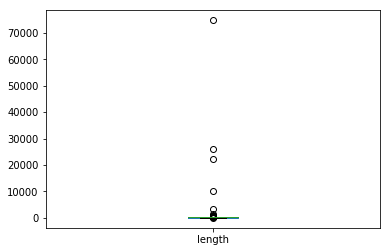

In [99]:
references_df.length.plot(kind='box')
references_df.length.describe()

In [100]:
references_df[references_df.length > 1000]

,ref,file,length,initial
114,p ...............................................,import2016full_93,22395,p
862,nalysis .........................................,import2016full_92,74737,n
1897,Pages 1-702: Volume 1 Pages 703-1407: Volume 2...,import2016full_91,26188,P
9343,for collaborative learning moderates the relat...,import2016short_136,3336,f
10746,"Dijkstra, Pieternel, Hans Kuyper, Greetje van ...",import2018_323,1335,D
12489,"Wenger, E. (1998). Communities of practice: Le...",import2016short_145,10097,W


One paper that uses ACM format:

In [102]:
references_df.iloc[10746].ref

'Dijkstra, Pieternel, Hans Kuyper, Greetje van der Werf, Abraham P. Buunk, and Yvonne G. van der Zee. 2008. “Social Comparison in the Classroom: A Review.” Review of Educational Research 78 (4). American Educational Research Association:828–79. Festinger, Leon. 1954. “A Theory of Social Comparison Processes.” Human Relations; Studies towards the Integration of the Social Sciences 7 (2). SAGE Publications:117–40. Graesser, Arthur C., Danielle S. McNamara, Zhiqang Cai, Mark Conley, Haiying Li, and James Pennebaker. 2014. “Coh-Metrix Measures Text Characteristics at Multiple Levels of Language and Discourse.” The Elementary School Journal 115 (2):210–29. Régner, Isabelle, and Jean-Marc Monteil. 2007. “Low-and High-Socioeconomic Status Students Preference for Ingroup Comparisons and Their Underpinning Ability Expectations.” Revue Internationale de Psychologie Sociale 20 (1). Presses univ. de Grenoble:87–104. Tu, Chih-Hsiung, and Marina McIsaac. 2002. “The Relationship of Social Presence an

h    4
b    3
p    3
Ö    3
e    2
n    2
a    2
t    2
Ø    1
f    1
r    1
1    1
Ž    1
[    1
Å    1
Name: initial, dtype: int64

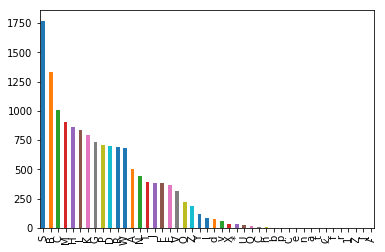

In [103]:
references_df.initial.value_counts().plot(kind='bar')
references_df.initial.value_counts().tail(15)

In [104]:
#short references are fine
references_df[references_df.length < 40]

,ref,file,length,initial
3724,"Wilensky, U. (1999). {NetLogo}.",import2017_9,31,W
4140,"Wilensky, U. (1999). {NetLogo}.",import2018_1,31,W
5093,"Wilensky, U. (1999). {NetLogo}.",import2016short_106,31,W
6391,1855,import2018_513,4,1
9378,no. 1 (2000): 1–25.,import2018_269,19,n


In [105]:
#also correctly parsed i, e are fine, a are not too bad, leave it
#only very few references are incorrect if they start by lowercase. we accept this
#b is correct
references_df[references_df['initial'] == 'b']

,ref,file,length,initial
3045,"boyd, d. (2014). It’s complicated: The social ...",import2018_176,109,b
3671,"boyd, d. (2009). Why Youth (Heart) Social Netw...",import2015full_285,110,b
4620,"boyd, d. (2009). Why Youth (Heart) Social Netw...",import2015short_285,110,b


Remove overly long references are they are due to badly parsed pdfs:

In [106]:
references_df = references_df[(references_df.length < 1000)]

In [107]:
print('We can parse references from {} documents.'.format(references_df.file.value_counts().shape[0]))

We can parse references from 865 documents.


Example reference:

In [108]:
references_df[references_df.length < 200].sample(5).ref.tolist()

['Lim, M. & Barton, A. (2006). Science learning and a sense of place in an urban middle school. Cultural Studies in Science Education 1(1), 107-142.',
 'Demirer, V., & Sahin, I. (2013). Effect of blended learning environment on transfer of learning: An experimental study. Journal of Computer Assisted Learning, 29, 518-529.',
 'Duschl, R. (2008). Science education in three-part harmony: Balancing conceptual, epistemic, and social learning goals. Review of Research in Education, 32(1), 268–291.',
 'Ford, M. J. (2015). Educational implications of choosing “practice” to describe science in the Next Generation Science Standards. Science Education, 99(6), 1041-1048.',
 'Sherman, M. & Martin, F. (2015), The assessment of mobile computational thinking. Journal of Computing Sciences in Colleges. 30(6), 53–59.']

# Approach to get names from references:

For APA style it is easy to extract the year and author of the cited reference
- we could look at from when the reference cited is, who is in it

Need to look at efficient way to check name validity:
think spanish, irish names

In [109]:
def get_authors(sentence, debug = False):
    regex = r'[\S\s]*\((18|19|20)\d{2}[\,\ \w\d]*\)'
    if re.search(regex, sentence):
        s = re.findall(regex, sentence)[0]
        if len(s) > 9:
            return (s)
    elif debug:
        return '#'+sentence
    
    return np.nan


import regex as reg

def get_authors_month(sentence, debug = False):
    regex = r'[éüş\xad\p{L}\,\ \.\:\;\/\&\-\'\`\(\)\’\–\¨\…\‐\*\´\＆\\]*\([\,\ \p{L}\d\-]*(18|19|20)\d{2}[\,\ \p{L}\d\-]*\)'
    match_bad_year = r'[\S\s]*\((18|19|20)\d{2}\/(18|19|20)\d{2}\)'
    
    match_press = r'[\S\s]*\((i|I)n (P|p)ress|manuscript under review\)'
    match_forth = r'[\S\s]*\((f|F)orthcoming\)'
    match_accepted = r'[\S\s]*\((a|A)ccepted\)'
    match_submitted = r'[\S\s]*\((s|S)ubmitted\)'
    match_underreview = r'[\S\s]*\((u|U)nder (R|r)eview\)'
    
    #sentence = sentence.lower()
    if reg.match(regex, sentence):
        s = reg.search(regex, sentence).group(0)
        if len(s) > 9:
            return s
    elif re.match(match_bad_year, sentence):
        return re.search(match_bad_year, sentence).group(0)
    elif re.match(match_press, sentence):
        return re.search(match_press, sentence).group(0)
    elif re.match(match_forth, sentence):
        return re.search(match_forth, sentence).group(0)
    elif re.match(match_accepted, sentence):
        return re.search(match_accepted, sentence).group(0)
    elif re.match(match_submitted, sentence):
        return re.search(match_submitted, sentence).group(0)
    elif re.match(match_underreview, sentence):
        return re.search(match_underreview, sentence).group(0)
    
    return np.nan

In [110]:
references_df['ref_parsed'] = references_df.apply(lambda x: get_authors_month(x['ref']), axis=1)

In [111]:
print('Percentage of unparsed references: {:0.2f}'.format(references_df.ref_parsed.isna().sum()/references_df.ref_parsed.shape[0]))
print('Number of unparsed references: ', references_df[references_df.ref_parsed.isna()].ref.shape[0])
print('Number of properly parsed references: ', references_df.ref_parsed.shape[0])

Percentage of unparsed references: 0.00
Number of unparsed references:  54
Number of properly parsed references:  14680


Unpased files:

In [112]:
references_df[references_df.ref_parsed.isna()].ref.tolist()

['American Association for the Advancement of Science (AAAS; 2016). Benchmarks for Science Literacy. New York, Oxford University Press. Retrieved from www.AAAS.org.',
 'Journal of Systems and Software, 86(5), 1390-1407. EEF. (2017). Education Endownment Foundation: Teaching & Learning Toolkit: Collaborative learning.',
 'P21 Framework Definitions (2009). Partnership for 21st Century Skills. Retrieved from http://www.p21.org/storage/documents/P21_Framework_Definitions.pdf.',
 'Dewey, 1913. Dewey, J. (1913). Interest and effort in education. Boston, MA: Riverside Press.',
 'Gilbert (Ed.), Visualization in science education (pp. 121-145). Dordrecht, Netherlands: Springer. NRC. (2006). Learning to think spatially. Washington, D.C.: National Academies Press.',
 'Blikstein, P. Gears of our childhood: constructionist toolkits, robotics, and physical computing, past and future. Proceedings of the 12th International Conference on Interaction Design and Children, ACM (2013), 173–182.',
 'pedagog

In [113]:
l = ['/import2016full/95',
 '/import2016full/92',
 '/import2016full/93',
 '/import2016full/94',
 '/import2016full/91',
 '/import2016full/96',
 '/import2016full/98',
 '/import2016full/97']
references_df[references_df.file.map(lambda x: x in l)]

,ref,file,length,initial,ref_parsed


In [114]:
references_df.head()

,ref,file,length,initial,ref_parsed
0,"Lave, J., & Wenger, E. (1991). Situated learni...",import2018_371,108,L,"Lave, J., & Wenger, E. (1991)"
1,"Miles, M. B., Huberman, A. M., & Saldana, J. (...",import2018_371,107,M,"Miles, M. B., Huberman, A. M., & Saldana, J. (..."
2,"Pea, R. D., Gomez, L. M., Edelson, D. C., Fish...",import2018_371,294,P,"Pea, R. D., Gomez, L. M., Edelson, D. C., Fish..."
3,"Rogoff, B. (1995). Observing sociocultural act...",import2018_371,269,R,"Rogoff, B. (1995)"
4,"Shirk, J., Ballard, H., Wilderman, C., Phillip...",import2018_371,215,S,"Shirk, J., Ballard, H., Wilderman, C., Phillip..."


In [115]:
ref_counts = references_df.groupby('file').ref_parsed.count()
ref_counts.name = 'counts'
ref_counts.head()

file
import2015full_105    33
import2015full_122    33
import2015full_126    45
import2015full_136     8
import2015full_146    23
Name: counts, dtype: int64

In [116]:
ref_counts.describe()

count    865.000000
mean      16.908671
std       11.073606
min        0.000000
25%        8.000000
50%       15.000000
75%       23.000000
max       77.000000
Name: counts, dtype: float64

In [117]:
df = references_df.join(ref_counts, on='file')
df.head()

,ref,file,length,initial,ref_parsed,counts
0,"Lave, J., & Wenger, E. (1991). Situated learni...",import2018_371,108,L,"Lave, J., & Wenger, E. (1991)",5
1,"Miles, M. B., Huberman, A. M., & Saldana, J. (...",import2018_371,107,M,"Miles, M. B., Huberman, A. M., & Saldana, J. (...",5
2,"Pea, R. D., Gomez, L. M., Edelson, D. C., Fish...",import2018_371,294,P,"Pea, R. D., Gomez, L. M., Edelson, D. C., Fish...",5
3,"Rogoff, B. (1995). Observing sociocultural act...",import2018_371,269,R,"Rogoff, B. (1995)",5
4,"Shirk, J., Ballard, H., Wilderman, C., Phillip...",import2018_371,215,S,"Shirk, J., Ballard, H., Wilderman, C., Phillip...",5


We see that only papers that are invalid have no citation

In [121]:
df[df.counts == 0].ref.tolist()

['Shayan Doroudi and Emma Brunskill. The misidentified identifiability problem of Bayesian Knowledge Tracing. In Educational Data Mining, pages 143–149. International Educational Data Mining Society, 2017. Shayan Doroudi, Ece Kamar, Emma Brunskill, and Eric Horvitz. Toward a learning science for complex crowdsourcing tasks. In Proceedings of the 2016 CHI Conference on Human Factors in Computing Systems, pages 2623–2634. ACM, 2016. Shayan Doroudi, Vincent Aleven, and Emma Brunskill. Robust Evaluation Matrix: Towards a more principled offline exploration of instructional policies. In Proceedings of the Fourth (2017) ACM Conference on Learning@ Scale, pages 3–12. ACM, 2017. 1882']

In [38]:
df[df.counts == 3]

,ref,file,length,initial,ref_parsed,counts
3306,"Bransford, J. D., Brown, A. L., Cocking, R. R....",import2016short/168,191,B,"Bransford, J. D., Brown, A. L., Cocking, R. R....",3
3307,National Research Council. (2012). A framework...,import2016short/168,300,N,National Research Council. (2012),3
3308,DC: The National Academies Press. U.S. Departm...,import2016short/168,193,D,DC: The National Academies Press. U.S. Departm...,3


In [122]:
references_df[references_df.file == '/import2016short/136']

,ref,file,length,initial,ref_parsed


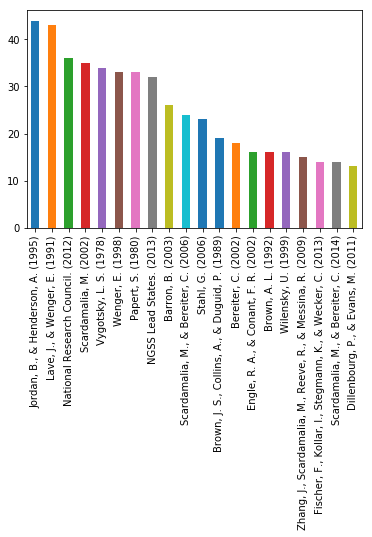

In [123]:
references_df.ref_parsed.value_counts().head(20).plot(kind='bar')

# extracting information for individual references:
## Extracting the year of publication:

In [124]:
def extract_year(x):
    match_press = r'\(in press\)'
    years = r'\([\w\d\,\ \.]*(18|19|20)\d{2}[\,\ \w\d]*\)'
    year = re.search(years, x)
    if re.search(match_press, x):
        return 2018
    if year:
        year = year.group(0)
        year = re.findall('\d{4}', year)
        return int(year[0])
    else:
        return np.nan

In [125]:
references_df.loc[~references_df.ref_parsed.isna(),'year'] = references_df[~references_df.ref_parsed.isna()].ref_parsed.map(extract_year)

In [126]:
references_df[references_df.year.isna()].shape

(166, 6)

In [127]:
references_df.year.describe()

count    14514.00000
mean      2006.07324
std         10.11591
min       1887.00000
25%       2002.00000
50%       2009.00000
75%       2013.00000
max       2018.00000
Name: year, dtype: float64

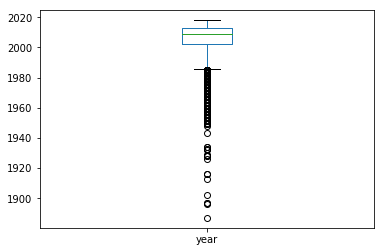

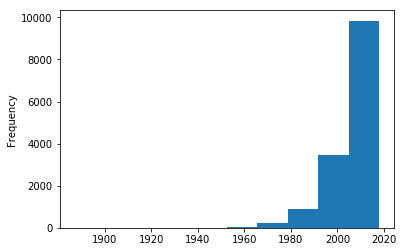

In [128]:
references_df.year.plot(kind='box')
plt.show()
references_df.year.plot(kind='hist')

In [46]:
references_df.to_csv('data/References.csv')

## Look at individual authors:

For now we look only the the authors that come up in any citation in the paper. So we do not care about order or the specific reference they are associated with:

We again use a regex to extract neighbours

In [129]:
authors = 'Yoon, S., Anderson, E., Koehler-Yom, Evans, C., Park, M., J., Sheldon, J., Schoenfeld, I., Wendel, D., Scheintaub, H., Klopfer, E.'

In [130]:
re.findall(r'([A-Z][^\W\d_\-]*\,?\&? [A-Z]\.\,?)', authors)

['Yoon, S.,',
 'Anderson, E.,',
 'Evans, C.,',
 'Park, M.,',
 'Sheldon, J.,',
 'Schoenfeld, I.,',
 'Wendel, D.,',
 'Scheintaub, H.,',
 'Klopfer, E.']

A change of local seems to allow for better parsing!

In [131]:
import locale
locale.setlocale(locale.LC_ALL, 'de_DE')

'de_DE'

In [132]:
regex = r'([\w\-]*[\,] [A-Z\.\ ]+[\&\,]?)'

In [133]:
authors = 'Abrahamson, D., Snüàchez-Gärca, R. S. ,'
re.findall(regex, authors, re.U)

['Abrahamson, D.,', 'Snüàchez-Gärca, R. S. ,']

In [134]:
#extract authors and clean strings a bit
regex = r'([\w\-]*[\,] [A-Z\.\ ]+[\&\,]?)'
authors = references_df[~references_df.ref_parsed.isna()].ref_parsed.map(lambda x: re.findall(regex, x) ).tolist()
authors = [ [a.replace(',', '').replace('&', '').rstrip() for a in l] for l in authors ]

In [135]:
proto_frame = list(zip(authors, references_df[~references_df.ref_parsed.isna()].file.tolist()))

In [136]:
#extract authors!
authors_frame = pd.DataFrame([(i, index) for (l, index ) in proto_frame for i in l], columns=['author', 'file'])

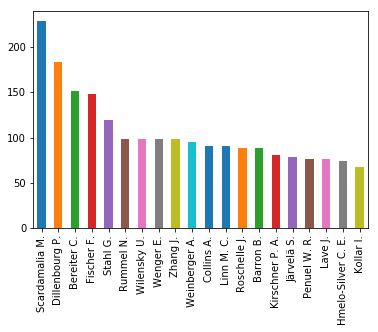

In [137]:
authors_frame.author.value_counts().head(20).plot(kind='bar')

In [139]:
authors_frame.author.value_counts().head(10)

Scardamalia M.    229
Dillenbourg P.    184
Bereiter C.       152
Fischer F.        148
Stahl G.          119
Rummel N.          99
Wilensky U.        99
Wenger E.          98
Zhang J.           98
Weinberger A.      95
Name: author, dtype: int64

In [140]:
authors_frame.to_csv('data/Reference_authors.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'data/Reference_authors.csv'

## Trying to extract the conference

In [141]:
references_df[references_df.ref.map(lambda x: 'CHI' in x)].shape

(82, 6)

In [59]:
text = references_df.sample().ref.item()
re.split(r'\. (?=[A-Z][A-Za-z])', text)

['Pandya, C., Batalova, J., & McHugh, M. (2011)',
 'Limited English proficient individuals in the United States: Number, share, growth, and linguistic diversity',
 'Washington, D.C.: Migration Policy Institute.']

In [60]:
references_df[references_df.ref.map(lambda x: 'CHI' in x)].sample(4).ref.tolist()

['Fallman, D. (2003). Design-oriented Human–Computer Interaction. Proceedings of the Conference on Human Factors in Computing Systems, CHI 2003, ACM Press, pp. 225–232.',
 'Olson, J. S., Olson, G. M., & Meader, D. K. (1995). What mix of video and audio is useful for remote real-time work? In Proceedings of CHI ’95 (pp. 362–368). New York: ACM Press.',
 'Hornecker, E., & Buur, J. (2006). Getting a Grip on Tangible Interaction: A Framework on Physical Space and Social Interaction. In Proceedings of the SIGCHI Conference on Human Factors in Computing Systems (pp. 437–446). New York, NY, USA: ACM.',
 'Schneider, B. (2014). The Perceptual Benefits of a Tangible Interface Decrease with Users’ Expertise. In CHI ’14 Ext. Abstracts on Human Factors in Computing Systems (963–968). New York, NY, USA: ACM.']

In [61]:
references_df[references_df.ref.map(lambda x: 'ICLS' in x)].shape

(56, 6)

In [62]:
text= '/hdfk/2017/r8475'
re.search('\d{3}(0|2|4|6|8)', text)

In [63]:
references_df['conference'] = references_df.file.map(lambda x: 'ICLS' if re.search('\d{3}(0|2|4|6|8)', x) else 'CSCL')

In [64]:
references_df[references_df.ref.map(lambda x: 'CSCL' in x)].conference.value_counts()

CSCL    301
ICLS     72
Name: conference, dtype: int64

In [65]:
references_df[references_df.ref.map(lambda x: 'ICLS' in x)].conference.value_counts()

CSCL    43
ICLS    13
Name: conference, dtype: int64

conference
CSCL    AxesSubplot(0.125,0.125;0.775x0.755)
ICLS    AxesSubplot(0.125,0.125;0.775x0.755)
Name: counts, dtype: object

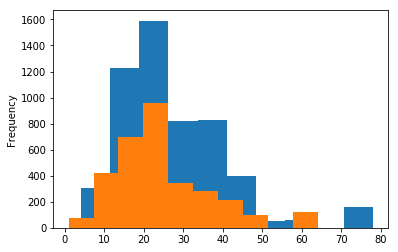

In [66]:
references_df.join(ref_counts, on='file').groupby('conference').counts.plot(kind='hist')

In [67]:
references_df.conference.value_counts()

CSCL    5432
ICLS    3212
Name: conference, dtype: int64

In [68]:
references_df.groupby('file').conference.value_counts()

file                conference
import2015full/105  CSCL          33
import2015full/122  CSCL          33
import2015full/126  CSCL          45
import2015full/136  CSCL           8
import2015full/146  CSCL          23
import2015full/150  CSCL          20
import2015full/154  CSCL          21
import2015full/158  CSCL          39
import2015full/162  CSCL          47
import2015full/165  CSCL          34
import2015full/167  CSCL          34
import2015full/169  CSCL          35
import2015full/171  CSCL          21
import2015full/172  CSCL          17
import2015full/176  CSCL          22
import2015full/178  CSCL           9
import2015full/182  CSCL          14
import2015full/185  CSCL          19
import2015full/189  CSCL          28
import2015full/191  CSCL          29
import2015full/192  CSCL          24
import2015full/197  CSCL          21
import2015full/204  CSCL          16
import2015full/206  CSCL          24
import2015full/209  CSCL          78
import2015full/217  CSCL          10
import2

## trying to parse acm authors

We see that there aren't that many, so we won't parse them for not

In [69]:
ACM_authors = []
for i, ref in enumerate(references):
    for sentence in ref:
        s =  re.findall(r'[a-zA-Z\ \. \,]*\d{4}\. ', sentence)
        if re.match(r'[a-zA-Z\ \. \,]*\d{4}\. ', sentence) and not 'http' in s[0].lower() and len(s[0]) > 10:
            #print(sentence)
            print(s[0])
            #apa_authors.append((re.findall(r'.*\(\d{4}\)', sentence)[0], source[i]))

Eisenhardt, K. M. 2000. 
Campbell, L., and B. Campbell. 2009. 
with ScienceKit. Paper presented at CSCL 2015. 
Edmondson, A. C. 1999. 
supports collaboration in a tabletop activity. In Proceedings of GROUP 2014. 
sketching practices in a learning by design task. Paper presented at CSCL 2013. 
Systems, ITS2011. 
Stahl, G., 2006. 
Gilbert, Jane. 2005. 
Dewey, 1913. 
Gee, J. P. 2011. 
Innovating Pedagogy 2012. 
Edmondson, A. C. 1999. 
supports collaboration in a tabletop activity. In Proceedings of GROUP 2014. 
sketching practices in a learning by design task. Paper presented at CSCL 2013. 
Systems, ITS2011. 
Stahl, G., 2006. 
In Advanced Learning Technologies, 2003. 
Milheim, K. 2007. 
Condition of Education 2015. 
In Ubiquitous Virtual Reality, 2009. 
of Oregon, 1968. 
Dillenbourg, P. 1999. 
Halverson, E.R. and Sheridan, K. 2014. 
Klahr, D. and Nigam, M. 2004. 
supports collaboration in a tabletop activity. In Proceedings of GROUP 2014. 
the Proceedings of International Conference of Le

In [70]:
re.match(r'(.*\d{4}\. )', "https://www.nsf.gov/funding/pgm_summ.jsp?pims_id=5467. Retrieved August 19, 2016.")

<re.Match object; span=(0, 55), match='https://www.nsf.gov/funding/pgm_summ.jsp?pims_id=>

In [71]:
m = re.match(r'.*\d{4}\. ', 'https://www.nsf.gov/funding/pgm_summ.jsp?pims_id=5467. Retrieved August 19, 2016.')

In [72]:
re.findall(r'[a-zA-Z\ \. \,]*\d{4}\. ', 'McKenzie, W., and Murphy, D. 2000. “I hope this goes somewhere”: Evaluation of an on')

['McKenzie, W., and Murphy, D. 2000. ']